In [1]:
# Bibliotecas ----
import os
import json
import requests
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain


In [2]:
ultima_reuniao = requests.get("https://www.bcb.gov.br/api/servico/sitebcb/copom/atas?quantidade=1").json()
nro_ultima_reuniao = ultima_reuniao["conteudo"][0]["nroReuniao"]
nro_ultima_reuniao

In [4]:
quantidade = 12 # de reuniões passadas

In [5]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.docstore.document import Document

documentos = []
for num in list(range(nro_ultima_reuniao - quantidade, nro_ultima_reuniao + 1)):
    url = f'https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao='
    ata = WebBaseLoader(f"{url}{num}").load()
    conteudo = json.loads(ata[0].page_content)["conteudo"][0]['textoAta']
    dia_ref = json.loads(ata[0].page_content)["conteudo"][0]["dataReferencia"]
    documentos.append(Document(page_content = conteudo,
                               metadata = {"data": dia_ref}))


In [6]:
# Autenticação na API do Google
os.environ["GOOGLE_API_KEY"] = open('passgooglestudio.txt', 'r').read()

In [7]:
# Definição do modelo LLM
llm = ChatGoogleGenerativeAI(model = "gemini-pro", temperature = 0)
# Engenharia de prompt
llm_prompt = PromptTemplate.from_template("""
Você é um cientista de dados experiente em machine learning e em NLP, dominando
as técnicas de análise de sentimentos. Sua tarefa é analisar o sentimento do
texto a seguir. Retorne o sentimento do texto em um índice de 0 a 100, sendo 0 o
sentimento mais negativo, 100 o sentimento mais positivo e 50 o sentimento neutro:

"{DOCUMENTO}"

Índice:""")

# Combinar prompt, texto da ata e modelo
llm_chain = LLMChain(llm = llm, prompt = llm_prompt)

quantificador = StuffDocumentsChain(llm_chain = llm_chain,document_variable_name = "DOCUMENTO")

sentimento = []
reuniao = []
for doc in documentos:
    sentimento.append(quantificador.invoke(input = [doc], return_only_outputs = True)["output_text"])
    reuniao.append(doc.metadata["data"])

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 8.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 16.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 32.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<l

In [8]:
tabela = pd.DataFrame()
tabela['data'] = pd.to_datetime(reuniao)
tabela['sentimento'] = sentimento
tabela['sentimento'] = tabela['sentimento'].astype(int)
tabela

,data,sentimento
0,2023-02-01,50
1,2023-03-22,45
2,2023-05-03,55
3,2023-06-21,55
4,2023-08-02,75
5,2023-09-20,75
6,2023-11-01,75
7,2023-12-13,65
8,2024-01-31,65
9,2024-03-20,60


In [9]:
import plotly.graph_objects as go

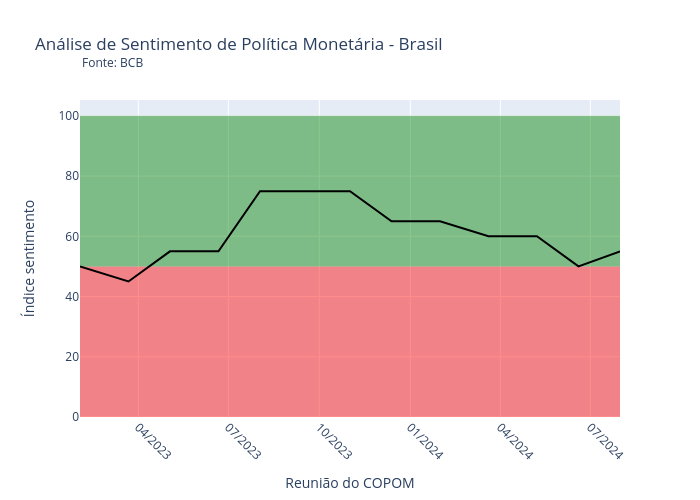

In [10]:


linha_sentimento = go.Scatter(x=tabela['data'],y=tabela['sentimento'],mode='lines',line_color='black',name='Sentimento',showlegend=False)
# Criar as áreas de fundo
area_negativa = go.Scatter(
    x=tabela['data'],
    y=[50] * len(tabela),  # Linha horizontal em y=50
    mode='lines',
    line=dict(width=0, color='red'), # Linha invisível
    fill='tonexty', # Preencher até a próxima linha
    fillcolor='rgba(255, 0, 0, 0.45)',  # Vermelho com transparência
    showlegend=False
)

area_positiva = go.Scatter(
    x=tabela['data'],
    y=[100] * len(tabela), # Linha horizontal em y=100
    mode='lines',
    line=dict(width=0, color='green'), # Linha invisível
    fill='tonexty', # Preencher até a próxima linha
    fillcolor='rgba(0, 128, 0, 0.45)',  # Verde com transparência
    showlegend=False
)

# Criar o objeto figura e adicionar os traços
fig = go.Figure(data=[area_negativa, area_positiva, linha_sentimento])

# Personalizar o layout
fig.update_layout(
    title="Análise de Sentimento de Política Monetária - Brasil",
    xaxis_title="Reunião do COPOM",
    yaxis_title="Índice sentimento",
    xaxis_tickformat="%m/%Y",
    xaxis_tickangle=45,
    
    # Adicionar nota como anotação
    annotations=[dict(
        x=0, 
        y=1.15, 
        xref="paper", 
        yref="paper", 
        text="Fonte: BCB",
        showarrow=False
    )]
)


fig.show("png")  # para github
# fig.show()       # Grafico interativo


In [11]:
from langchain_community.document_loaders import PyPDFLoader 
from langchain.schema import StrOutputParser
from langchain.schema.prompt_template import format_document

no_reuniao = str(ultima_reuniao["conteudo"][0]["nroReuniao"])
data_refer = str(ultima_reuniao["conteudo"][0]["dataReferencia"]).replace("-", "")
url_ata = f"https://www.bcb.gov.br/content/copom/atascopom/Copom{no_reuniao}-not{data_refer+no_reuniao}.pdf"

# Coleta de dados ----
pdf = PyPDFLoader(url_ata)
ata = pdf.load_and_split()

In [12]:
doc_prompt = PromptTemplate.from_template("{page_content}") # extrai texto do PDF

llm_prompt = PromptTemplate.from_template("""
Você é um economista chefe experiente em análise de política monetária, tendo
trabalhado em fundos de investimentos e grandes bancos, além de ser PhD em
economia.

Sua tarefa é ler a ata a seguir da Reunião do Comitê de Política Monetária (Copom)
do Banco Central do Brasil e classificar o documento em hawkish ou dovish:

"{ata}"

Classificação:""") # prompt para o Gemini

# Combinar prompt, texto da ata e modelo
classificador = (
    {"ata": lambda ata: "\n\n".join(
      format_document(pagina, doc_prompt) for pagina in ata
      )}
    | llm_prompt
    | llm
    | StrOutputParser()
)

classificador.invoke(ata[2:8])

'Hawkish'

In [13]:
classificador.invoke(ata)

'Hawkish'